### Import the necessary modules

In [ ]:
import os
import tensorflow as tf
from tensorboard.plugins import projector
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Read in the CSV file containing the California sales data for Quarters 1 and 2

Then examine the data's shape and first few rows

In [ ]:
df_sales = pd.read_csv("sales_Q12_2019.csv")
print(df_sales.shape)
df_sales.head()

(5837, 76)


,main_S60_1,main_S60_2,main_type_SP100D,main_type_S60D_1,main_type_S60D_2,main_type_S70,main_type_S70D,main_type_S75,main_type_S75D,main_type_S80,main_type_S80D,main_type_S85,main_type_S85P,main_type_P85D,main_type_S90,main_type_S90D,main_type_S100D,engine_A,engine_B,engine_C,engine_D,engine_E,engine_F,engine_G,engine_H,engine_I,engine_J,engine_K,engine_L,engine_M,engine_N,engine_O,engine_P,engine_Q,engine_R,engine_S,engine_T,engine_U,engine_V,engine_W,engine_X,engine_Y,engine_Z,sales_1,sales_2,sales_3,sales_4,sales_5,sales_6,sales_7,sales_8,sales_9,sales_10,sales_11,sales_12,sales_13,sales_14,sales_15,sales_16,sales_17,sales_18,sales_19,sales_20,sales_21,sales_22,sales_23,sales_24,sales_25,sales_26,sales_27,sales_28,sales_29,sales_30,MSRP,dealer_state,date
0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,44610,California,2019-04-28
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,41505,California,2019-03-14
2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,58890,California,2019-06-12
3,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,51055,California,2019-03-04
4,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,70830,California,2019-01-23


### Begin cleaning the data

Eliminate the `'dealer_state'` and `'date'` columns. The former is useless to our model, since we already know that our dataset is restricted to California sales. While we could possibly extract useful information from the `'date'` column (for example, to determine whether more cars are sold on weekends than weekdays), we'll be focusing on car configurations instead.

In [ ]:
df_sales = df_sales.drop(columns=['dealer_state','date'])
df_sales.head()

,main_S60_1,main_S60_2,main_type_SP100D,main_type_S60D_1,main_type_S60D_2,main_type_S70,main_type_S70D,main_type_S75,main_type_S75D,main_type_S80,main_type_S80D,main_type_S85,main_type_S85P,main_type_P85D,main_type_S90,main_type_S90D,main_type_S100D,engine_A,engine_B,engine_C,engine_D,engine_E,engine_F,engine_G,engine_H,engine_I,engine_J,engine_K,engine_L,engine_M,engine_N,engine_O,engine_P,engine_Q,engine_R,engine_S,engine_T,engine_U,engine_V,engine_W,engine_X,engine_Y,engine_Z,sales_1,sales_2,sales_3,sales_4,sales_5,sales_6,sales_7,sales_8,sales_9,sales_10,sales_11,sales_12,sales_13,sales_14,sales_15,sales_16,sales_17,sales_18,sales_19,sales_20,sales_21,sales_22,sales_23,sales_24,sales_25,sales_26,sales_27,sales_28,sales_29,sales_30,MSRP
0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,44610
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,41505
2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,58890
3,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,51055
4,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,70830


### Read in the CSV file containing the California sales data for Quarters 3 and 4

In [ ]:
# Read in the Q34 data
df_pred = pd.read_csv("sales_Q34_2019.csv")
# Print the shape of the data
print(np.shape(df_pred))
# Examine the first few rows of the data
df_pred.head()

(6666, 74)


,main_S60_1,main_S60_2,main_type_SP100D,main_type_S60D_1,main_type_S60D_2,main_type_S70,main_type_S70D,main_type_S75,main_type_S75D,main_type_S80,main_type_S80D,main_type_S85,main_type_S85P,main_type_P85D,main_type_S90,main_type_S90D,main_type_S100D,engine_A,engine_B,engine_C,engine_D,engine_E,engine_F,engine_G,engine_H,engine_I,engine_J,engine_K,engine_L,engine_M,engine_N,engine_O,engine_P,engine_Q,engine_R,engine_S,engine_T,engine_U,engine_V,engine_W,engine_X,engine_Y,engine_Z,sales_1,sales_2,sales_3,sales_4,sales_5,sales_6,sales_7,sales_8,sales_9,sales_10,sales_11,sales_12,sales_13,sales_14,sales_15,sales_16,sales_17,sales_18,sales_19,sales_20,sales_21,sales_22,sales_23,sales_24,sales_25,sales_26,sales_27,sales_28,sales_29,sales_30,MSRP
0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,51355
1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,71580
2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,66790
3,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,72330
4,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,55370


# Task I. Consolidate data by finding numbers of unique car combinations sold for training and test data sets

73 of the 74 columns in the Q12 and Q34 datasets are one-hot-encoded representations of the car's `'main_type'`, `'engine'`, and `'sales_version'` values. The final column is the car's `'MSRP'`, or manufacturer's (Tesla's, in this case) suggested retail price. In its current form, the sales data doesn't contain a target. The car's `'main_type'`, `'engine'`, `'sales_version'`, and `'MSRP'` values are all known to us before the time of the sale and do not, by themselves, offer us anything which we can predict. 

However, each row represents the sale of a single car. If we define a unique car type by its combination of `'main_type'`, `'engine'`, and `'sales_version'` values, the number of rows displaying that combination corresponds to the number of times during that half of the year that that distinct type of car was sold in California. Therefore, we can make training and test datasets where each row now corresponds to a unique car type, and the target value is how many times that car type was sold in California during a given half of the year.


In [ ]:
def get_features_and_targets(df):
    # Create the local data DataFrame as a copy of the input df DataFrame, minus the 'MSRP' column
    data = df.drop(columns=['MSRP'])
    # Use the value_counts() method for DataFrames to store the targets as a NumPy array of the 
    # normalized sales counts associated with each unique combination of 'main_type', 'engine', 
    # and 'sales_version' values in the data DataFrame
    Y = np.array(data.value_counts(sort=False, normalize=True))[:, np.newaxis] 
    # Get a list of the column names of the data DataFrame
    subset_names = data.columns.values.tolist()
    # Use the drop_duplicates() method on the df DataFrame to store the features data as a NumPy array where
    # each row corresponds to a unique combination of 'main_type', 'engine', and 'sales_version' values
    X = np.array(df.drop_duplicates(subset=subset_names))
    # Scale and shift the 'MSRP' column so its values fall in the range [0,1]
    X[:,-1] = ( X[:,-1] - min(X[:,-1]) ) / np.ptp(X[:,-1])
    # Return features and targets
    return X, Y

### Extract features and targets as defined above from both the Q12 and Q34 datasets

In [ ]:
# Extract training features and targets from the Q12 data
train_X, train_Y = get_features_and_targets(df_sales)
# Extract test features and targets from the Q34 data
test_X, test_Y = get_features_and_targets(df_pred)
print(f"Number of unique cars in Q12 = {len(train_Y)}")
print(f"Number of unique cars in Q34 = {len(test_Y)}")

Number of unique cars in Q12 = 66
Number of unique cars in Q34 = 71


It's seen that the Q12 and Q34 datasets contained differing numbers of distinct cars. Clearly, some new models were introduced by Q3, but were any discontinued by the end of Q2?

In [ ]:
# How many unique cars in 2012 (Q1:Q4)?
# Concatenate the Q12 and Q34 DataFrames into a single DataFrame
df_full = pd.concat([df_sales, df_pred])
# Extract features and targets from the concatenated Q14 data
data_X, data_Y = get_features_and_targets(df_full)
print(f"Number of unique cars in Q12 and Q34 = {len(data_Y)}")

Number of unique cars in Q12 and Q34 = 80


The following probability equations are true for any two events $A$ and $B$:

$$P (A \cup B) = P(A) + P(B) - P (A \cap B)$$
$$P(A) = P (A \cap B) + P (A \cap B^c)$$

Use these equations to determine how many car models were sold in both halves of 2019, how many were discontinued by the second half of the year, and how many were launched in the second half of the year.

In [ ]:
models_q12_or_q34 = len(data_Y)
models_q12 = len(train_Y)
models_q34 = len(test_Y)
models_q14 = models_q12 + models_q34 - models_q12_or_q34
discontinued = models_q12 - models_q14
launched = models_q34 - models_q14
print(f"{models_q14} models were sold throughout 2019")
print(f"{discontinued} models were discontinued by the second half of 2019")
print(f"{launched} models were launched in the second half of 2019")

57 models were sold throughout 2019
9 models were discontinued by the second half of 2019
14 models were launched in the second half of 2019


# Task II: Visualize the training and test targets any way you see fit

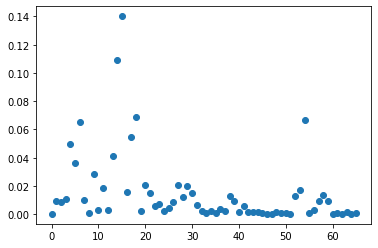

In [ ]:
# Visualize the training targets
plt.scatter(range(len(train_Y)), train_Y)
plt.show()

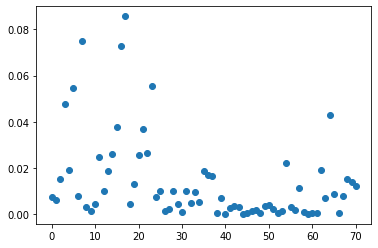

In [ ]:
# Visualize the test targets
plt.scatter(range(len(test_Y)), test_Y)
plt.show()

# Task III: Apply Gradient Descent (Linear, Polynomial)

Initialize the $\theta$ parameters as a column vector of zeros, one for every feature in the training data plus one for bias. 

Also set hyperparameters for learning rate and maximum number of iterations through the training data.

In [ ]:
# learned parameters theta and hyperparameters
s_theta = np.zeros((train_X.shape[1]+1, 1))
s_learning_rate = 0.001
s_max_iteration = 1000

### Hypothesis Function

Define your hypothesis function $h$ (which you use to make predictions $\hat{Y}$ as the matrix product of your features data X and parameters theta, in that order. 

Don't forget to add a 0th column of ones to X to account for the bias/offset parameter.

In [ ]:
# hypothesis function
def h (theta, X) :
    tempX = np.ones((X.shape[0], X.shape[1] + 1))
    tempX[:,1:] = X
    return np.matmul(tempX, theta)

Define your loss function as **half** the MSE (mean squared error) between your actual and predicted Y values. 

Recall that the predicted Y values are a function of theta and X.


In [ ]:
# loss Function
def loss (theta, X, Y) :
    return np.average(np.square(Y - h(theta, X))) / 2

### Gradient of Hypothesis Function

One can verify through straightforward (if somewhat tedious) multivariable calculus that the gradient of the loss function $J$ with respect to the parameters $\theta$ is 

$$ \frac{\partial J}{\partial \theta} = - \frac{1}{m} X^T \cdot (Y - \hat{Y})$$.

Here, $X$ has been augmented with a bias column. 

Set up a function to compute this gradient.

In [ ]:
# gradient of hypothesis function
def gradient (theta, X, Y) :
    # Create a temporary X array with an added 0th bias column
    tempX = np.ones((X.shape[0], X.shape[1] + 1))
    tempX[:,1:] = X
    # Compute the gradient according to the instructions above
    d_theta = - np.dot(tempX.T, Y - h(theta, X)) / X.shape[0]
    return d_theta

### Gradient Descent

Set up a function to train the linear regression model with gradient descent.

In [ ]:
def stochastic_gradient_descent (theta, X, Y, learning_rate, max_iteration, gap) :
    # Initialize the cost as an array of zeros, one for each iteration through the dataset
    cost = np.zeros(max_iteration)
    # Loop over the dataset
    for i in range(max_iteration):
        # Loop over each row in the dataset
        for j in range(X.shape[0]):
            # Compute the gradient from the current row in X and the associated Y value
            # Make sure that both X and Y are represented as 2D row vectors
            d_theta = gradient (theta, X[np.newaxis, j, :], Y[np.newaxis, j, :])
            # Update theta
            theta = theta - learning_rate * d_theta
        # Update the cost array for the current iteration
        cost[i] = loss(theta, X, Y)
        if i % gap == 0 :
            print ('iteration : ', i, ' loss : ', loss(theta, X, Y)) 
    return theta, cost

In [ ]:
s_theta, s_cost = stochastic_gradient_descent(s_theta, train_X, train_Y, s_learning_rate, s_max_iteration, 100)

iteration :  0  loss :  0.0004206533214992532
iteration :  100  loss :  0.0002422983467552357
iteration :  200  loss :  0.00021788868167880285
iteration :  300  loss :  0.00020533288342740923
iteration :  400  loss :  0.00019779653985861766
iteration :  500  loss :  0.00019286413605363375
iteration :  600  loss :  0.0001894284804626956
iteration :  700  loss :  0.00018691690844249828
iteration :  800  loss :  0.00018500756875786407
iteration :  900  loss :  0.0001835079702943847


### Generate Predictions from Test Data

In [ ]:
GD_P = h(s_theta,test_X)
# Set any negative predictions to 0
GD_P[GD_P<0] = 0

### Visualize the predicted and actual test labels

RMSE, R2 using SGD= 0.000518924229453394 0.6939013195958598


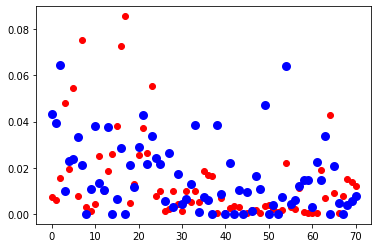

In [ ]:
plt.scatter(range(len(test_Y)), test_Y,  color='red')
plt.scatter(range(len(GD_P)), GD_P, color='blue', linewidth=3)
from sklearn.metrics import mean_squared_error as MSE

# This function evaluates the R**2 statistic
def r2(Yt,Yp):
    yhat = Yp                         
    ybar = np.sum(Yt)/len(Yt)          
    ssreg = np.sum((yhat-ybar)**2)   
    sstot = np.sum((Yt - ybar)**2)    
    results = ssreg / sstot
    return results


print("RMSE, R2 using SGD=", MSE(test_Y,GD_P), r2(test_Y,GD_P))

# Task IV: Normal Equations

Since our training dataset isn't very large, let's generate predictions using the normal equations: 

$$W = (X^T \cdot X)^{-1} \cdot X^T \cdot Y$$ 
$$\hat{Y} = W^T \cdot X$$

and see how they compare to the predictions which we obtained from gradient descent.

In [ ]:
# Compute W using the first of the Normal Equations
W1 = np.matmul(np.linalg.pinv(np.matmul(train_X.T, train_X)), 
               np.matmul(train_X.T, train_Y))
# Compute the predicted Y values using the second of the Normal Equations
PN1 = np.matmul(test_X, W1)

# Set any negative predictions to 0
PN1[np.where(PN1<0)]=0

RMSE, R2 for prediction all features = 0.0005596570062877893 0.8479142625775232


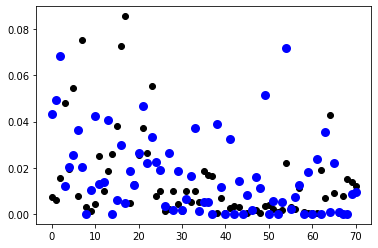

In [ ]:
# Plot outputs
plt.scatter(range(len(test_Y)), test_Y,  color='black')
plt.scatter(range(len(PN1)), PN1, color='blue', linewidth=3)
print("RMSE, R2 for prediction all features =", MSE(test_Y,PN1), r2(test_Y,PN1)) #[Low error high corr]

### Regularized Normal Equations

In [ ]:
print('Recall that our training features array train_X has')
print(f'm = {train_X.shape[0]} rows and n = {train_X.shape[1]} columns')

`train_X` is thus wider than it is tall, which suggests that the regularized normal equations might perform better in generating label predictions. In this case, we modify the first of the normal equations given above to 

$$W = (X^T \cdot X + \lambda m I)^{-1} \cdot X^T \cdot Y$$.

Here, $\lambda$ is the regularization parameter and $m$ is the number of rows in $X$.

### Repeat the previous parts of Task IV, but this time incorporate regularization

In [ ]:
# set parameters
lamb = 0.05
m = train_X.shape[0]
I = np.identity(train_X.shape[1])

# compute regularized weights
W2 = np.linalg.pinv(train_X.T.dot(train_X) + lamb*m*I).dot(train_X.T.dot(train_Y))

# make predictions
PN2 = test_X.dot(W2)

# set negative predictions to 0 
PN2[np.where(PN2<0)] = 0

RMSE, R2 for prediction all features = 0.0004110466479439014 0.31327760833561563


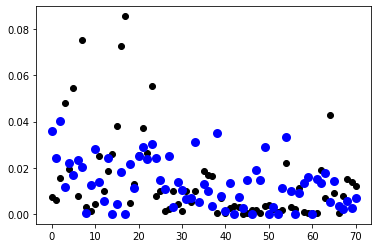

In [ ]:
# Plot outputs
plt.scatter(range(len(test_Y)), test_Y,  color='black')
plt.scatter(range(len(PN2)), PN2, color='blue', linewidth=3)
print("RMSE, R2 for prediction all features =", MSE(test_Y,PN2), r2(test_Y,PN2)) #[Low error high corr]

# Task V: Non-linear Regression Models (GLM, DT) 

### Generalized Linear Models

`sm` (our alias for `statsmodels.api`) contains a `GLM` class. Use it to instantiate a model. The relevant parameters are training labels, training features, and `ffamily`, i.e. the family of distributions to which we assume our prediction errors belong. Some potentially good choices for `ffamily` include Gaussian, Gamma, and Logit.

In [ ]:
# GLM 
import statsmodels.api as sm
# Instantiate the GLM
glm_gamma = sm.GLM(train_Y, train_X, family=sm.families.Gaussian())
# Train the GLM
glm_results = glm_gamma.fit()
print(glm_results.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                   66
Model:                            GLM   Df Residuals:                       34
Model Family:                Gaussian   Df Model:                           31
Link Function:               identity   Scale:                      0.00066625
Method:                          IRLS   Log-Likelihood:                 169.60
Date:                Fri, 31 Dec 2021   Deviance:                     0.022652
Time:                        22:34:33   Pearson chi2:                   0.0227
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.968e-17   3.03e-17      0.981      0.3

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:1294: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse


### Generate predictions from the test data

In [ ]:
G_P = glm_results.predict(test_X)

# Set any negative predictions to 0
G_P[G_P<0]=0

RMSE, R2 for GLM= 0.0005596570062877873 0.847914262577519


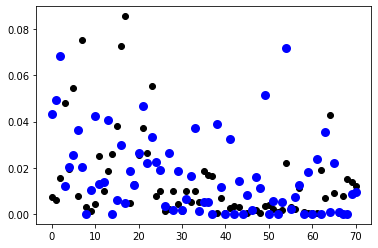

In [ ]:
# Plot outputs
plt.scatter(range(len(test_Y)), test_Y,  color='black')
plt.scatter(range(len(G_P)), G_P, color='blue', linewidth=3)
print("RMSE, R2 for GLM=", MSE(test_Y,G_P), r2(test_Y,G_P)) 

### Random Forest Regression

Use the `RandomForestRegressor` from `sklearn.ensemble` to generate predictions. The relevant parameters are the `max_depth` of the trees and the `random_state`, to ensure reproducibility.

In [ ]:
from sklearn.ensemble import RandomForestRegressor
# Instantiate the random forest regression model
regr = RandomForestRegressor()
# Train the model
regr.fit(train_X, train_Y)
# Generate predictions from the test data
pred_rf = regr.predict(test_X)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


In [ ]:
# Set any negative predictions to 0
pred_rf[np.where(pred_rf<0)]=0

RMSE, R2 for Decision Trees= 0.0006205765595940541 0.9105296210571829


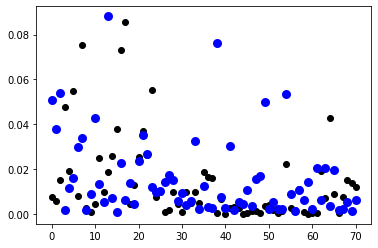

In [ ]:
# Plot outputs
plt.scatter(range(len(test_Y)), test_Y,  color='black')
plt.scatter(range(len(pred_rf)), pred_rf, color='blue', linewidth=3)
print("RMSE, R2 for Decision Trees=", MSE(test_Y,pred_rf), r2(test_Y,pred_rf)) #[Low error high corr]